Part 2 Training and Evaluation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.api.types import is_numeric_dtype
%matplotlib inline

## 1. Load and split preprocessed data
- Some Weekly_Sales data are zero, result in too large metrics because of devided by zero. So change all zero values to 0.01.
- Split dataset acoording to date. Use older data to train and newer data to test
- train:test = 4:1

In [ ]:
df = pd.read_csv('./datasets/W store sales/result_data.csv')
# use high correlation columns in part 1 correlation analysis
df = df[["Date", "Weekly_Sales", "Store", "Size", "Dept", "Type", "Dept_num", "Size_per_dept"]]

# fix zero values
for index, row in df[df['Weekly_Sales']==0].iterrows():
    df.at[index, 'Weekly_Sales'] = row['Weekly_Sales'] + 0.01

# Split dataset acoording to date
test_ratio = 0.2
train_dates = df["Date"].unique()[:-int(test_ratio*len(df["Date"].unique()))]
test_dates = df["Date"].unique()[-int(test_ratio*len(df["Date"].unique())):]
numeric_columns = [col for col in df.columns if is_numeric_dtype(df[col]) and col!='Weekly_Sales']
df_train = df[df["Date"].isin(train_dates)]
df_test = df[df["Date"].isin(test_dates)]

x_train = df_train[numeric_columns]
x_test = df_test[numeric_columns]
y_train = df_train["Weekly_Sales"]
y_test = df_test["Weekly_Sales"]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((338738, 6), (82832, 6), (338738,), (82832,))

## 2. Train and test models
- Compare 3 models from 3 types of classic models:
  - Liner model: LinearRegression
  - Distance-based model: KNeighborsRegressor
  - Tree-based model: RandomForestRegressor
- Use GridSearch and cross validation to tune hyper-parameters.

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

Use metrics: MAE, MAPE, RMSE, R2

In [4]:
from sklearn.metrics import  mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
def getScores(model):
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "MAPE": mape,  "RMSE": rmse, "R2": r2}

scores = {}

LinearRegression

In [5]:
model_Linear = LinearRegression()
model_Linear.fit(x_train, y_train)
print(getScores(model_Linear))
scores["LinearRegression"] = getScores(model_Linear)

{'MAE': 14507.824056640164, 'MAPE': 1633.968839158143, 'RMSE': 20913.771048166138, 'R2': 0.09361543060358302}


KNN

In [6]:
model_KNN = KNeighborsRegressor()
parameters = {'n_neighbors':[3, 10]}
grid_KNN = GridSearchCV(model_KNN, parameters, cv=2)
grid_KNN.fit(x_train,y_train)
print("Best params: ", grid_KNN.best_params_)
print(getScores(grid_KNN))
scores["KNN"] = getScores(grid_KNN)

Best params:  {'n_neighbors': 10}
{'MAE': 3466.7569236889126, 'MAPE': 122.59440241438622, 'RMSE': 6924.454262014283, 'R2': 0.9006383244013826}


RandomForest

In [7]:
model_forest = RandomForestRegressor()
parameters = {'n_estimators':[10, 30, 50], 'max_depth':[4, 10, 50]}
grid_forest = GridSearchCV(model_forest, parameters, cv=2)
grid_forest.fit(x_train,y_train)
print("Best params: ", grid_forest.best_params_)
print(getScores(grid_forest))
scores["RandomForest"] = getScores(grid_forest)

Best params:  {'max_depth': 10, 'n_estimators': 30}
{'MAE': 4113.527826516951, 'MAPE': 186.44157679883472, 'RMSE': 7036.152000611912, 'R2': 0.8974068816673428}


## 3. Evaluate the model
Compare MAE, MAPE, RMSE, R2 of three models:
- Performance of KNN and RandomForest are similar and they are vey higher than LinearRegresiion

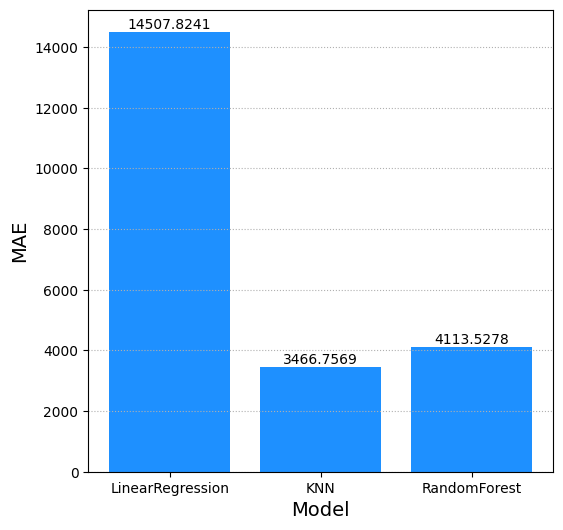

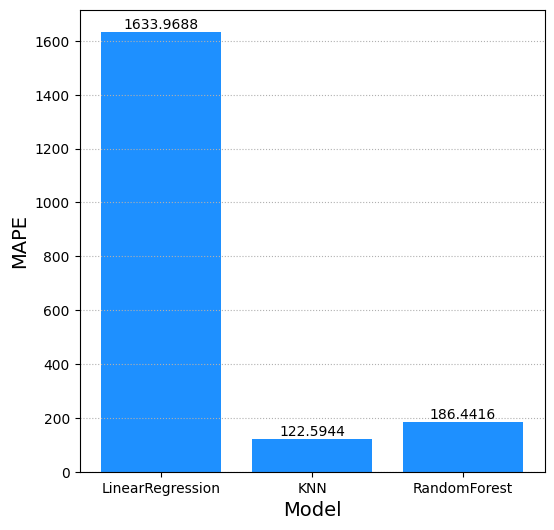

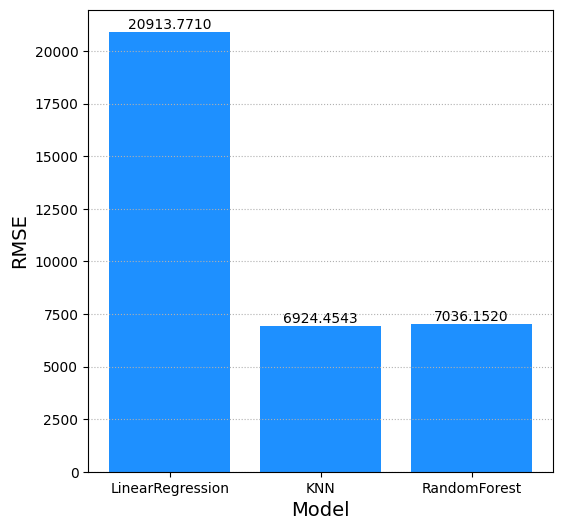

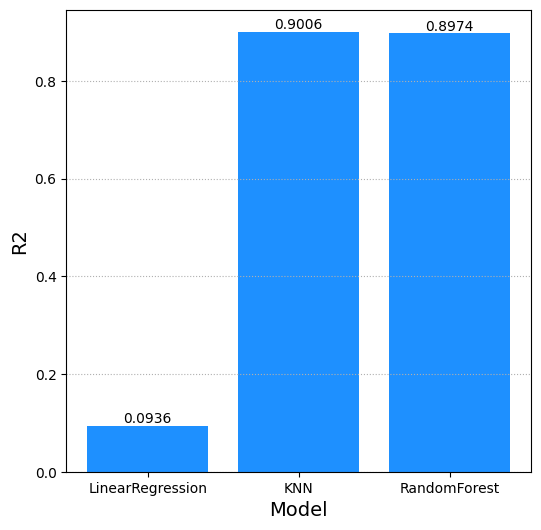

In [9]:
mae = [scores[k]['MAE'] for k in scores.keys()]
mape = [scores[k]['MAPE'] for k in scores.keys()]
rmse = [scores[k]['RMSE'] for k in scores.keys()]
r2 = [scores[k]['R2'] for k in scores.keys()]

def drawMetrics(metric, models, values):
    plt.figure(figsize=(6,6))
    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.grid(linestyle=':', axis='y')
    x = np.arange(len(models))
    plt.bar(x, values, color='dodgerblue', align='center')
    for i in range(len(values)):
        plt.text(i, values[i], '%.4f' % values[i], ha='center', va='bottom')
    plt.xticks(x, models)
    plt.show()

drawMetrics('MAE', scores.keys(), mae)
drawMetrics('MAPE', scores.keys(), mape)
drawMetrics('RMSE', scores.keys(), rmse)
drawMetrics('R2', scores.keys(), r2)

## 4. Ensemble Learning
- Use KNN and RandomForest to build a VotingRegressor which has a better Performance on MAE, RMSE and R2.

In [13]:
from sklearn.ensemble import VotingRegressor
model_KNN = KNeighborsRegressor(n_neighbors=10)
model_forest = RandomForestRegressor(n_estimators=30, max_depth=10)
model_voting = VotingRegressor(estimators=[ ('knn', model_KNN), ('rf', model_forest)], weights=[2, 1])
model_voting.fit(x_train, y_train)
print(getScores(model_voting))

{'MAE': 3350.94954962541, 'MAPE': 143.63847710800408, 'RMSE': 6447.67363572152, 'R2': 0.9138502745476542}


## 5. Visualize predicted data
- Using all columns to train have a better curve fitting

C:\Users\Francis\AppData\Local\Temp\ipykernel_19168\3513846171.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_test[df["Store"]==store][df["Dept"]==dept].Date, y_test[df["Store"]==store][df["Dept"]==dept], marker='o', label="Test Actual")
C:\Users\Francis\AppData\Local\Temp\ipykernel_19168\3513846171.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_test[df["Store"]==store][df["Dept"]==dept].Date, y_test[df["Store"]==store][df["Dept"]==dept], marker='o', label="Test Actual")
C:\Users\Francis\AppData\Local\Temp\ipykernel_19168\3513846171.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_test[df["Store"]==store][df["Dept"]==dept].Date, y_pred[df["Store"]==store][df["Dept"]==dept], marker='o', label="Test Predict")
C:\Users\Francis\AppData\Local\Temp\ipykernel_19168\3513846171.py:25: UserWarning: Boolean Series key will be reindexed to match DataFr

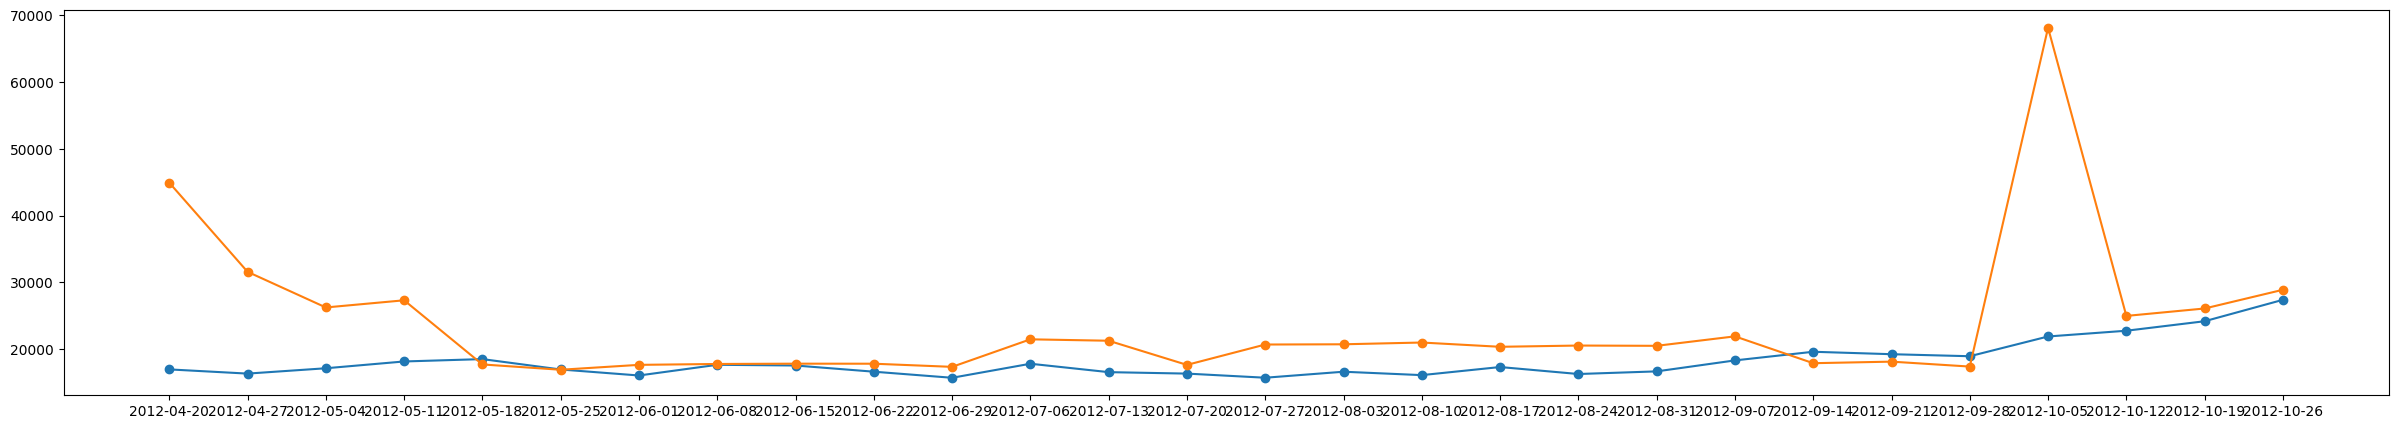

In [ ]:
df = pd.read_csv('./datasets/W store sales/result_data.csv')
for index, row in df[df['Weekly_Sales']==0].iterrows():
    df.at[index, 'Weekly_Sales'] = row['Weekly_Sales'] + 0.01
test_ratio = 0.2
train_dates = df["Date"].unique()[:-int(test_ratio*len(df["Date"].unique()))]
test_dates = df["Date"].unique()[-int(test_ratio*len(df["Date"].unique())):]
numeric_columns = [col for col in df.columns if is_numeric_dtype(df[col]) and col!='Weekly_Sales']
df_train = df[df["Date"].isin(train_dates)]
df_test = df[df["Date"].isin(test_dates)]
x_train = df_train[numeric_columns]
x_test = df_test[numeric_columns]
y_train = df_train["Weekly_Sales"]
y_test = df_test["Weekly_Sales"]


model = RandomForestRegressor(n_estimators=10)
model.fit(x_train, y_train)

predictions = model.predict(x_test)
y_pred = pd.Series(predictions, index=y_test.index)
plt.figure(figsize=(30,5))
store = 1
dept = 1
plt.plot(df_test[df["Store"]==store][df["Dept"]==dept].Date, y_test[df["Store"]==store][df["Dept"]==dept], marker='o', label="Test Actual")
plt.plot(df_test[df["Store"]==store][df["Dept"]==dept].Date, y_pred[df["Store"]==store][df["Dept"]==dept], marker='o', label="Test Predict")
plt.show()

## 6. Summary

### 1. Split dataset
- Use high correlation columns in part 1 correlation analysis
- Fix zero values of Weekly_Sales.
- Split dataset acoording to date. train:test = 4:1.
  
### 2. Train and Test models
- Train LinearRegression, KNN, RandomForest, and get scores on test dataset.

### 3. Evalution
- Compare MAE, MAPE, RMSE, R2 metrics.
  - Performance of KNN and RandomForest are similar and they are vey higher than LinearRegresiion

### 4. Emsemble Learning
- Use KNN and RandomForest to build a VotingRegressor which has a better Performance.

### 5. Visualize predicted data
- Using all columns to train have a better curve fitting